In [1]:
from datasets import load_dataset

train_dataset = load_dataset("json", data_files="..\datasets\\midas-discourse\\hi\\train.json", \
                             split="train")

Found cached dataset json (C:/Users/arifa/.cache/huggingface/datasets/json/default-fb31cf4673d07f98/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


In [2]:
val_dataset = load_dataset("json", data_files="..\datasets\\midas-discourse\\hi\\val.json", \
                             split="train")

Found cached dataset json (C:/Users/arifa/.cache/huggingface/datasets/json/default-734b2070b0487e52/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


In [3]:
test_dataset = load_dataset("json", data_files="..\datasets\\midas-discourse\\hi\\test.json", \
                             split="train")

Found cached dataset json (C:/Users/arifa/.cache/huggingface/datasets/json/default-ffa656dadf83379c/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


In [4]:
from datasets import Dataset, DatasetDict

datasets = DatasetDict()
datasets['train'] = train_dataset
datasets['validation'] = val_dataset
datasets['test'] = test_dataset

In [5]:
datasets

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Story_no', 'id', 'Discourse Mode'],
        num_rows: 7974
    })
    validation: Dataset({
        features: ['Sentence', 'Story_no', 'id', 'Discourse Mode'],
        num_rows: 997
    })
    test: Dataset({
        features: ['Sentence', 'Story_no', 'id', 'Discourse Mode'],
        num_rows: 997
    })
})

In [6]:
datasets["train"][:5]

{'Sentence': ['पाँच साल गुजर गये।',
  " बिरजू के माँ ने आँगन से निकल गाँव की ओर कान लगा कर सुनने की चेष्टा की-' उँहुँ, इतनी देर तक भला पैदल जानेवाले रुके रहेंगे?' पूर्णिमा का चाँद सिर पर आ गया है।",
  ' कुछ लोग घर वाले होते हैं, कुछ लोग सीढ़ीयों के पीछे सोने वाले होते हैं, कुछ लोग गालियां देते हैं, कुछ लोग गालियां सहते हैं।',
  'राम खिलावन ने अपनी कोठरी में जाकर अन्दर से दरवाज़ा लगा लिया और लाठी को चूल्हे में जला दी।',
  " इन्होंने कहा' शहर कोतवाल का अधिकार पूर्ण शब्द उनके कानों में गूंज गया।"],
 'Story_no': [24, 19, 1, 47, 47],
 'id': ['4669', '3296', '237', '9030', '9082'],
 'Discourse Mode': ['Narrative',
  'Narrative',
  'Descriptive',
  'Narrative',
  'Dialogue']}

In [7]:
datasets.set_format("pandas")

In [8]:
# get label counts for both classes
label_counts = datasets["train"]["Discourse Mode"].value_counts()
num_labels = (len(label_counts.keys()))

In [9]:
label_counts

Discourse Mode
Descriptive      2912
Narrative        2489
Dialogue         2361
Argumentative     105
Informative        67
Other              40
Name: count, dtype: int64

In [10]:
datasets.reset_format()

In [11]:
from transformers import BertForSequenceClassification, BertConfig, CharacterBertModel, CharacterBertTokenizer

tokenizer = CharacterBertTokenizer(strip_accents=None, do_lower_case=None)

In [12]:
def tokenize_function(example):
    return tokenizer(example['Sentence'], truncation=True)
    #return tokenizer(example["text"], truncation=True, max_length=128)

In [13]:
datasets

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Story_no', 'id', 'Discourse Mode'],
        num_rows: 7974
    })
    validation: Dataset({
        features: ['Sentence', 'Story_no', 'id', 'Discourse Mode'],
        num_rows: 997
    })
    test: Dataset({
        features: ['Sentence', 'Story_no', 'id', 'Discourse Mode'],
        num_rows: 997
    })
})

In [14]:
from transformers import DataCollatorWithPadding

tokenized_datasets = datasets.map(tokenize_function, batched=True, remove_columns=['Story_no', 'Sentence', 'id'])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-fb31cf4673d07f98\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-10b4ee02697f7fd6.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-734b2070b0487e52\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-769e42c0b4034eb8.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-ffa656dadf83379c\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-3985f71888660e8e.arrow


In [15]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['Discourse Mode', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7974
    })
    validation: Dataset({
        features: ['Discourse Mode', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 997
    })
    test: Dataset({
        features: ['Discourse Mode', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 997
    })
})

In [16]:
def assign_label(example):
    mapping = {
    "Descriptive":0,
    "Narrative":1,
    "Dialogue":2,
    "Argumentative":3,
    "Informative":4,
    "Other":5
    }
    example['labels'] = mapping[example['Discourse Mode']]
    return example

In [17]:
tokenized_datasets = tokenized_datasets.map(assign_label).remove_columns('Discourse Mode')
tokenized_datasets.set_format("torch")
tokenized_datasets.column_names

Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-fb31cf4673d07f98\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-2920d8c2059b9e46.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-734b2070b0487e52\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-24a0c2272d17e6cc.arrow
Loading cached processed dataset at C:\Users\arifa\.cache\huggingface\datasets\json\default-ffa656dadf83379c\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-f1420a903837e8d4.arrow


{'train': ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'token_type_ids', 'attention_mask', 'labels']}

In [18]:
samples = [tokenized_datasets["train"][i] for i in range(5)]
samples

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] पाँच साल गुजर गये । [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

'>>> [CLS] बिरजू के माँ ने आँगन से निकल गाँव की ओर कान लगा कर सुनने की चेष्टा की -'उँहुँ, इतनी देर तक भला पैदल जानेवाले रुके रहेंगे?'पूर्णिमा का चाँद सिर पर आ गया है । [SEP]'

'>>> [CLS] कुछ लोग घर वाले होते हैं, कुछ लोग सीढ़ीयों के पीछे सोने वाले होते हैं, कुछ लोग गालियां देते हैं, कुछ लोग गालियां सहते हैं । [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

'>>> [CLS] राम खिलावन ने अपनी कोठरी में जाकर अन्दर से दरवाज़ा लगा लिया और लाठी को चूल्हे में जला दी । [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

'>>> [CLS] इन्होंने कहा'शहर कोतवाल का अधिकार पूर्ण शब्द उनके कानों में गूंज गया । [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [19]:
datasets["train"][:5]

{'Sentence': ['पाँच साल गुजर गये।',
  " बिरजू के माँ ने आँगन से निकल गाँव की ओर कान लगा कर सुनने की चेष्टा की-' उँहुँ, इतनी देर तक भला पैदल जानेवाले रुके रहेंगे?' पूर्णिमा का चाँद सिर पर आ गया है।",
  ' कुछ लोग घर वाले होते हैं, कुछ लोग सीढ़ीयों के पीछे सोने वाले होते हैं, कुछ लोग गालियां देते हैं, कुछ लोग गालियां सहते हैं।',
  'राम खिलावन ने अपनी कोठरी में जाकर अन्दर से दरवाज़ा लगा लिया और लाठी को चूल्हे में जला दी।',
  " इन्होंने कहा' शहर कोतवाल का अधिकार पूर्ण शब्द उनके कानों में गूंज गया।"],
 'Story_no': [24, 19, 1, 47, 47],
 'id': ['4669', '3296', '237', '9030', '9082'],
 'Discourse Mode': ['Narrative',
  'Narrative',
  'Descriptive',
  'Narrative',
  'Dialogue']}

In [20]:
from transformers import set_seed

set_seed(30)
# set_seed(42)

In [21]:
#### LOADING BERT FOR CLASSIFICATION ####

config = BertConfig.from_pretrained('bert-base-uncased', num_labels=num_labels)  # binary classification
model = BertForSequenceClassification(config=config)

In [22]:
model.bert.embeddings.word_embeddings  # wordpiece embeddings

Embedding(30522, 768, padding_idx=0)

In [23]:
#### REPLACING BERT WITH CHARACTER_BERT ####

character_bert_model = CharacterBertModel.from_pretrained(
    "E:\Documents\Character Bert\Hate Speech\character-bert-hindi")
model.bert = character_bert_model

Some weights of the model checkpoint at E:\Documents\Character Bert\Hate Speech\character-bert-hindi were not used when initializing CharacterBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing CharacterBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CharacterBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
import numpy as np
import evaluate

metric_fun = evaluate.load("accuracy")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    metric_result = metric_fun.compute(references=labels, predictions=predictions)
    return {
        "accuracy": metric_result["accuracy"],
    }

In [25]:
#  disable weights and biases logging
import os
os.environ["WANDB_DISABLED"] = "true"

In [27]:
from transformers import TrainingArguments

# batch_size = 16
batch_size = 32
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size


training_args = TrainingArguments(
    report_to = None,
    output_dir="models/bert-unigram-hindi-classifier",
    overwrite_output_dir=True,
    save_strategy="no",
    evaluation_strategy="epoch",
    #learning_rate=3e-5,
    learning_rate=2e-5,
    weight_decay=0.01,
    #weight_decay=0.02,
    #warmup_ratio = 0.1,
    #warmup_ratio = 0.05,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    #num_train_epochs=4,
    #push_to_hub=True,
    metric_for_best_model="accuracy",
    fp16=True,
    logging_steps=logging_steps,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [28]:
from transformers import EarlyStoppingCallback

early_stop = EarlyStoppingCallback(1, 1.0)

In [29]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    #train_dataset=entire_train,
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Using amp half precision backend


In [30]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 997
  Batch size = 32


{'eval_loss': 1.799253225326538,
 'eval_accuracy': 0.10130391173520562,
 'eval_runtime': 4.9853,
 'eval_samples_per_second': 199.99,
 'eval_steps_per_second': 6.419}

In [31]:
trainer.train()

***** Running training *****
  Num examples = 7974
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 750


Epoch,Training Loss,Validation Loss,Accuracy
1,0.722700,0.636089,0.755266
2,0.533600,0.606396,0.768305
3,0.404200,0.597708,0.794383


***** Running Evaluation *****
  Num examples = 997
  Batch size = 32
***** Running Evaluation *****
  Num examples = 997
  Batch size = 32
***** Running Evaluation *****
  Num examples = 997
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=750, training_loss=0.5526305825710297, metrics={'train_runtime': 169.5348, 'train_samples_per_second': 141.104, 'train_steps_per_second': 4.424, 'total_flos': 4.58916773257152e+16, 'train_loss': 0.5526305825710297, 'epoch': 3.0})

In [32]:
trainer.evaluate(tokenized_datasets["test"])

***** Running Evaluation *****
  Num examples = 997
  Batch size = 32


{'eval_loss': 0.577069878578186,
 'eval_accuracy': 0.794383149448345,
 'eval_runtime': 2.6385,
 'eval_samples_per_second': 377.862,
 'eval_steps_per_second': 12.128,
 'epoch': 3.0}

In [32]:
# trainer.save_model()

In [33]:
y_preds, y_true, _ = trainer.predict(tokenized_datasets["test"])

***** Running Prediction *****
  Num examples = 997
  Batch size = 32


In [34]:
y_preds = np.argmax(y_preds, axis=-1)

In [35]:
from sklearn.metrics import classification_report
target_names = ["Descriptive",
    "Narrative",
    "Dialogue",
    "Argumentative",
    "Informative",
    "Other"]
print(classification_report(y_true, y_preds,target_names=target_names))

               precision    recall  f1-score   support

  Descriptive       0.80      0.82      0.81       380
    Narrative       0.81      0.78      0.80       316
     Dialogue       0.77      0.83      0.80       272
Argumentative       0.00      0.00      0.00        13
  Informative       0.33      0.10      0.15        10
        Other       1.00      1.00      1.00         6

     accuracy                           0.79       997
    macro avg       0.62      0.59      0.59       997
 weighted avg       0.78      0.79      0.78       997



C:\Users\arifa\anaconda3\envs\character_bert\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arifa\anaconda3\envs\character_bert\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\arifa\anaconda3\envs\character_bert\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Text(0.5, 1.0, 'Confusion matrix for DA')

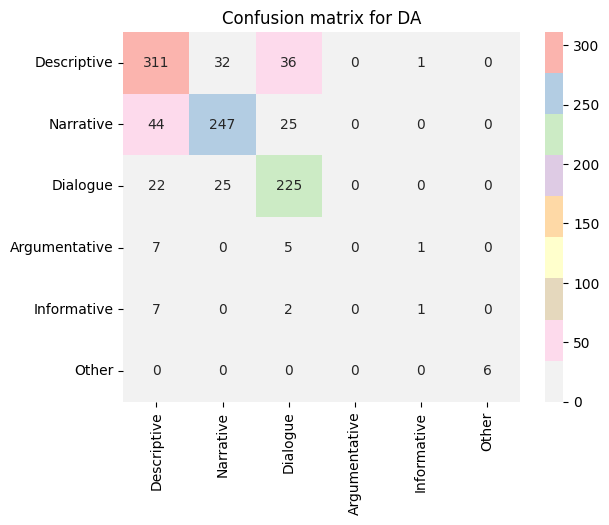

In [36]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

#plot heatmap of confusion matrix
mat = confusion_matrix(y_true, y_preds)
heatmap(mat, cmap="Pastel1_r", fmt="d", xticklabels=target_names, yticklabels=target_names, annot=True)

#add overall title to plot
plt.title('Confusion matrix for DA', fontsize = 12) # title with fontsize 20

In [37]:
misclassified = [i for i in range(len(y_preds)) if ((y_preds[i] != y_true[i]) and (y_true[i]==4) and (y_preds[i]==0))]

In [38]:
misclassified

[382, 412, 553, 628, 662, 695, 700]